Objectif : classification

Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy.core.numeric import cross
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import glob
import cv2
import time


In [2]:
tf.__version__

'2.6.0'

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Preprocessing 

In [4]:
# check whether GPU is provided
!nvcc --version
# check the architecture of my gpu
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:52:33_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
Tue Apr  5 11:09:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8     9W / 200W |   1272MiB /  8192MiB |     11%      Default |
|                    

Tests
Afficher une image

In [5]:
def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))

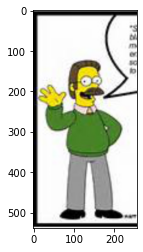

In [6]:
path = 'drive/MyDrive/tni/archive/train/ned_flanders/pic_0003.jpg'

img= cv2.imread(path)
cv2_imshow(img)

Prétraitement training

In [7]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    
)

training_set = train_datagen.flow_from_directory(
    'drive/MyDrive/tni/archive/train',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
Validation_set = train_datagen.flow_from_directory(
    'drive/MyDrive/tni/archive/train',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


Récupération des classes

Pretraitement testset

In [8]:
test_datagen = ImageDataGenerator(
    rescale= 1./255,
)
test_set = test_datagen.flow_from_directory(
    'drive/MyDrive/tni/archive/test',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical'
)

Found 950 images belonging to 19 classes.


Creer CNN

Inititalisation

In [9]:
cnn = tf.keras.models.Sequential()
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128,128,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Convolution/pooling

In [10]:
cnn.add(data_augmentation)
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(128,128,3)))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),dilation_rate=(1, 1),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),dilation_rate=(1, 1),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Flattenning

In [11]:
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.2))

Full connection (couches cachées)

In [12]:
cnn.add(tf.keras.layers.Dense(128, kernel_initializer="he_normal"))
cnn.add(tf.keras.layers.LeakyReLU(alpha=0.2))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.7))

Output Layer

In [13]:
cnn.add(tf.keras.layers.Dense(units=19,activation='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 952576)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 952576)            3810304   
_________________________________________________________________
dropout (Dropout)            (None, 952576)            0

Training model

In [14]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
)
history = cnn.fit(x=training_set,validation_data=Validation_set,epochs=40,callbacks=[early_stopping],use_multiprocessing=False)

Epoch 1/40
194/194 [==============================] - 81s 374ms/step - loss: 3.3257 - accuracy: 0.2188 - val_loss: 2.4754 - val_accuracy: 0.3500
Epoch 2/40
194/194 [==============================] - 61s 313ms/step - loss: 2.3763 - accuracy: 0.3622 - val_loss: 2.0477 - val_accuracy: 0.4565
Epoch 3/40
194/194 [==============================] - 61s 313ms/step - loss: 2.0305 - accuracy: 0.4299 - val_loss: 1.8056 - val_accuracy: 0.5066
Epoch 4/40
194/194 [==============================] - 62s 318ms/step - loss: 1.8307 - accuracy: 0.4807 - val_loss: 1.8260 - val_accuracy: 0.4756
Epoch 5/40
194/194 [==============================] - 64s 329ms/step - loss: 1.7292 - accuracy: 0.5104 - val_loss: 1.6987 - val_accuracy: 0.5228
Epoch 6/40
194/194 [==============================] - 58s 299ms/step - loss: 1.6362 - accuracy: 0.5326 - val_loss: 1.6342 - val_accuracy: 0.5286
Epoch 7/40
194/194 [==============================] - 60s 309ms/step - loss: 1.5649 - accuracy: 0.5562 - val_loss: 1.5665 - val_ac

15/15 - 3s - loss: 0.9659 - accuracy: 0.7389


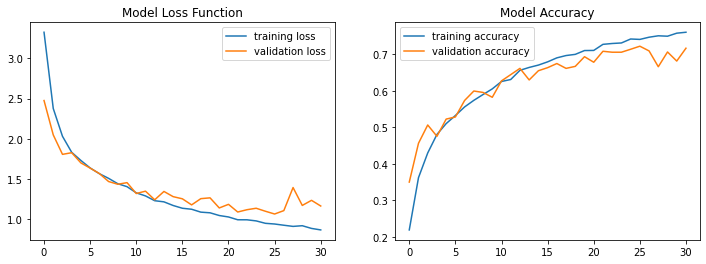

In [16]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend()

test_loss, test_acc = cnn.evaluate(test_set,verbose=2) 

Rapport sklearn.metrics.classification_report()

In [17]:
SEED = int(time.time())


absolute_path = os.path.abspath(os.curdir)
print(absolute_path)
main_path = "drive/MyDrive/tni/archive"
main_path = os.path.join(absolute_path, main_path)
train_path = os.path.join(main_path,"train")

filenames= os.listdir(train_path) # Récuperer les sous dossiers dans le chemin
names = []
for filename in filenames: # Attribuer un dossier à chaque nom
  names.append(filename)
train_list = []
names.sort()
for name in names:
  train_list.extend(glob.glob(train_path+"/"+name+"/*.jpg"))
name_img_counts = {}
for name in names:
  name_img_counts[name] = len(os.listdir(train_path+"/"+name))
print(name_img_counts)
np_array = []


for name in names:
  np_array = np.append(
  np_array, [(name[:8] + '..') if len(name) > 8 else name]*name_img_counts[name]
)

df_train = pd.DataFrame(np_array, columns = ['label'])
df_train['image'] = [x for x in train_list]


path = main_path+'/train'
#List of image:
img_list = list(df_train['image'])
data_img = []
for each in img_list:
  #Each image path:
  each_path = os.path.join(path, each)
  #Read each image:
  each_img = plt.imread(each_path)
  #Resize the images:
  each_img_resized = cv2.resize(each_img, (128,128))
  #Save arrays to a list:
  data_img.append(each_img_resized)
  # Converting list to numpy array

X = np.array(data_img)

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15,random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)

y_pred = cnn.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
print(classification_report(y_test_classes, y_pred_classes))

C:\Users\Thiba
{'abraham_grampa_simpson': 713, 'apu_nahasapeemapetilon': 423, 'bart_simpson': 1142, 'charles_montgomery_burns': 993, 'chief_wiggum': 786, 'comic_book_guy': 269, 'edna_krabappel': 257, 'homer_simpson': 2046, 'kent_brockman': 298, 'krusty_the_clown': 1006, 'lenny_leonard': 110, 'lisa_simpson': 1154, 'marge_simpson': 1091, 'milhouse_van_houten': 879, 'moe_szyslak': 1252, 'ned_flanders': 1254, 'nelson_muntz': 158, 'principal_skinner': 994, 'sideshow_bob': 677}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.40      0.03      0.06        63
           2       0.31      0.06      0.11       154
           3       0.45      0.36      0.40       168
           4       0.80      0.10      0.18       120
           5       0.20      0.26      0.23        46
           6       0.44      0.13      0.21        30
           7       0.37      0.56      0.44       288
           8       0.44      0.22   

C:\Users\Thiba\anaconda3\envs\classenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Thiba\anaconda3\envs\classenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Thiba\anaconda3\envs\classenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


coefficient de kappa du classeur

In [18]:
cohen_kappa_score(y_test_classes, y_pred_classes)

0.31653501418009133